In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt
from scipy.stats import poisson
import scipy

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data

In [2]:
path =r'..\\data'
epl1819 = pd.read_csv(path+"\\football-data EPL 18-19.csv")
epl1920 = pd.read_csv(path+"\\football-data EPL 19-20.csv")
epl2021 = pd.read_csv(path+"\\football-data EPL 20-21.csv")
dataset = pd.concat([epl1819, epl1920, epl2021])
dataset.reset_index(inplace=True)
dataset = dataset[["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR"]]
dataset["FTTG"] = dataset["FTHG"] + dataset["FTAG"]
dataset

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,FTTG
0,10/08/2018,Man United,Leicester,2,1,H,3
1,11/08/2018,Bournemouth,Cardiff,2,0,H,2
2,11/08/2018,Fulham,Crystal Palace,0,2,A,2
3,11/08/2018,Huddersfield,Chelsea,0,3,A,3
4,11/08/2018,Newcastle,Tottenham,1,2,A,3
...,...,...,...,...,...,...,...
1135,23/05/2021,Liverpool,Crystal Palace,2,0,H,2
1136,23/05/2021,Man City,Everton,5,0,H,5
1137,23/05/2021,Sheffield United,Burnley,1,0,H,1
1138,23/05/2021,West Ham,Southampton,3,0,H,3


In [3]:
# Create a unique code for each team
teams = dataset["HomeTeam"].unique()
teams = np.sort(teams)
n_teams = len(teams)
team_codes = [i for i in range(0, n_teams)]
team_codes_map = dict(zip(teams, team_codes))

# Add this unique code to the df
dataset["HomeTeamCode"] = dataset["HomeTeam"].apply(lambda x: team_codes_map[x])
dataset["AwayTeamCode"] = dataset["AwayTeam"].apply(lambda x: team_codes_map[x])

# Create pymc3 input: an array of home team codes, away team codes, home team goals, away team goals
home_goals = dataset["FTHG"].values
away_goals = dataset["FTAG"].values
home_team_code = dataset["HomeTeamCode"].values
away_team_code = dataset["AwayTeamCode"].values

# 2 The Model

# Model Specification
**Hyper Priors:**  
mu_att ~ Normal(0, 0.0001)  
mu_def ~ Normal(0, 0.0001)  
tau_att ~ Gamma(0.1, 0.1)  
tau_def ~ Gamma(0.1, 0.1)  

**Priors:**  
home ~ Normal(mean=0, precision=0.0001)  
att[i] ~ Normal(mu_att, tau_att)  
def[i] ~ Normal(mu_def, tau_def)  

**Determinsitic Transform:**  
theta_g1[g] = exp(home + att[i] + def[i])  
theta_g2[g] = exp(att[i] + def[i])

**Likelihood:**  
yg1[g] ~ Poisson(theta_g1[g])  
yg2[g] ~ Poisson(theta_g2[g])

In [4]:
with pm.Model() as model:
    
    # Hyper-priors
    #μ_att = pm.Normal('μ_att', mu=0., tau=0.0001)
    #μ_def = pm.Normal('μ_def', mu=0., tau=0.0001)
    
    τ_att = pm.Gamma('τ_att', 0.1, 0.1)
    τ_def = pm.Gamma('τ_def', 0.1, 0.1)    
    
    # Priors
    home = pm.Normal('home', mu=0., tau=0.0001)
    att_ = pm.Normal('att_', mu=0., tau=τ_att, shape=n_teams)
    deff_ = pm.Normal('deff_', mu=0., tau=τ_def, shape=n_teams)
    
    # Sum to 0 Constraint
    att = pm.Deterministic('att', att_ - tt.mean(att_))
    deff = pm.Deterministic('deff', deff_ - tt.mean(deff_))
    
    # Deterministic Transform
    θ_1 = tt.exp(att[home_team_code] + deff[away_team_code] + home)
    θ_2 = tt.exp(att[away_team_code] + deff[home_team_code])
    
    # Likelihood
    y_1 = pm.Poisson('y_1', mu=θ_1, observed=home_goals)
    y_2 = pm.Poisson('y_2', mu=θ_2, observed=away_goals)
    
    trace = pm.sample(2000, tune=1000, cores=6, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [deff_, att_, home, τ_def, τ_att]


Sampling 6 chains for 1_000 tune and 2_000 draw iterations (6_000 + 12_000 draws total) took 147 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'home'}>,
        <AxesSubplot:title={'center':'home'}>],
       [<AxesSubplot:title={'center':'att_'}>,
        <AxesSubplot:title={'center':'att_'}>],
       [<AxesSubplot:title={'center':'deff_'}>,
        <AxesSubplot:title={'center':'deff_'}>],
       [<AxesSubplot:title={'center':'τ_att'}>,
        <AxesSubplot:title={'center':'τ_att'}>],
       [<AxesSubplot:title={'center':'τ_def'}>,
        <AxesSubplot:title={'center':'τ_def'}>],
       [<AxesSubplot:title={'center':'att'}>,
        <AxesSubplot:title={'center':'att'}>],
       [<AxesSubplot:title={'center':'deff'}>,
        <AxesSubplot:title={'center':'deff'}>]], dtype=object)

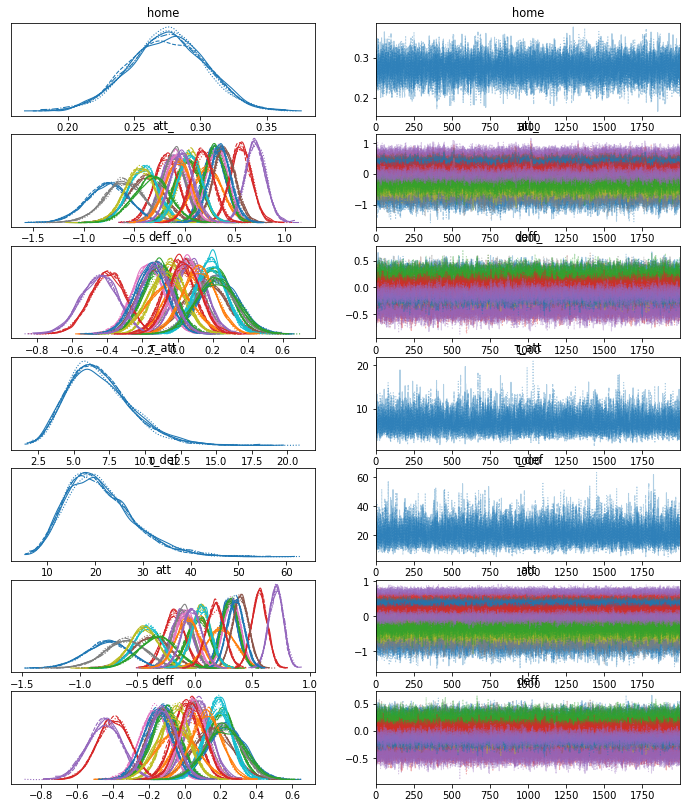

In [5]:
az.plot_trace(trace)

In [6]:
summary_trace = az.summary(trace)
summary_trace

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
home,0.275,0.029,0.223,0.330,0.000,0.000,16874.0,10251.0,1.0
att_[0],0.292,0.110,0.091,0.499,0.002,0.002,2456.0,4538.0,1.0
att_[1],0.036,0.129,-0.202,0.282,0.002,0.002,3287.0,5921.0,1.0
att_[2],0.030,0.130,-0.216,0.267,0.002,0.002,3594.0,5808.0,1.0
att_[3],-0.182,0.123,-0.408,0.053,0.002,0.002,3053.0,4753.0,1.0
...,...,...,...,...,...,...,...,...,...
deff[20],-0.153,0.082,-0.306,0.002,0.000,0.000,28418.0,8846.0,1.0
deff[21],0.122,0.083,-0.037,0.273,0.001,0.000,26260.0,9050.0,1.0
deff[22],0.224,0.107,0.024,0.423,0.001,0.001,26167.0,9224.0,1.0
deff[23],0.041,0.074,-0.101,0.176,0.000,0.001,31121.0,8854.0,1.0


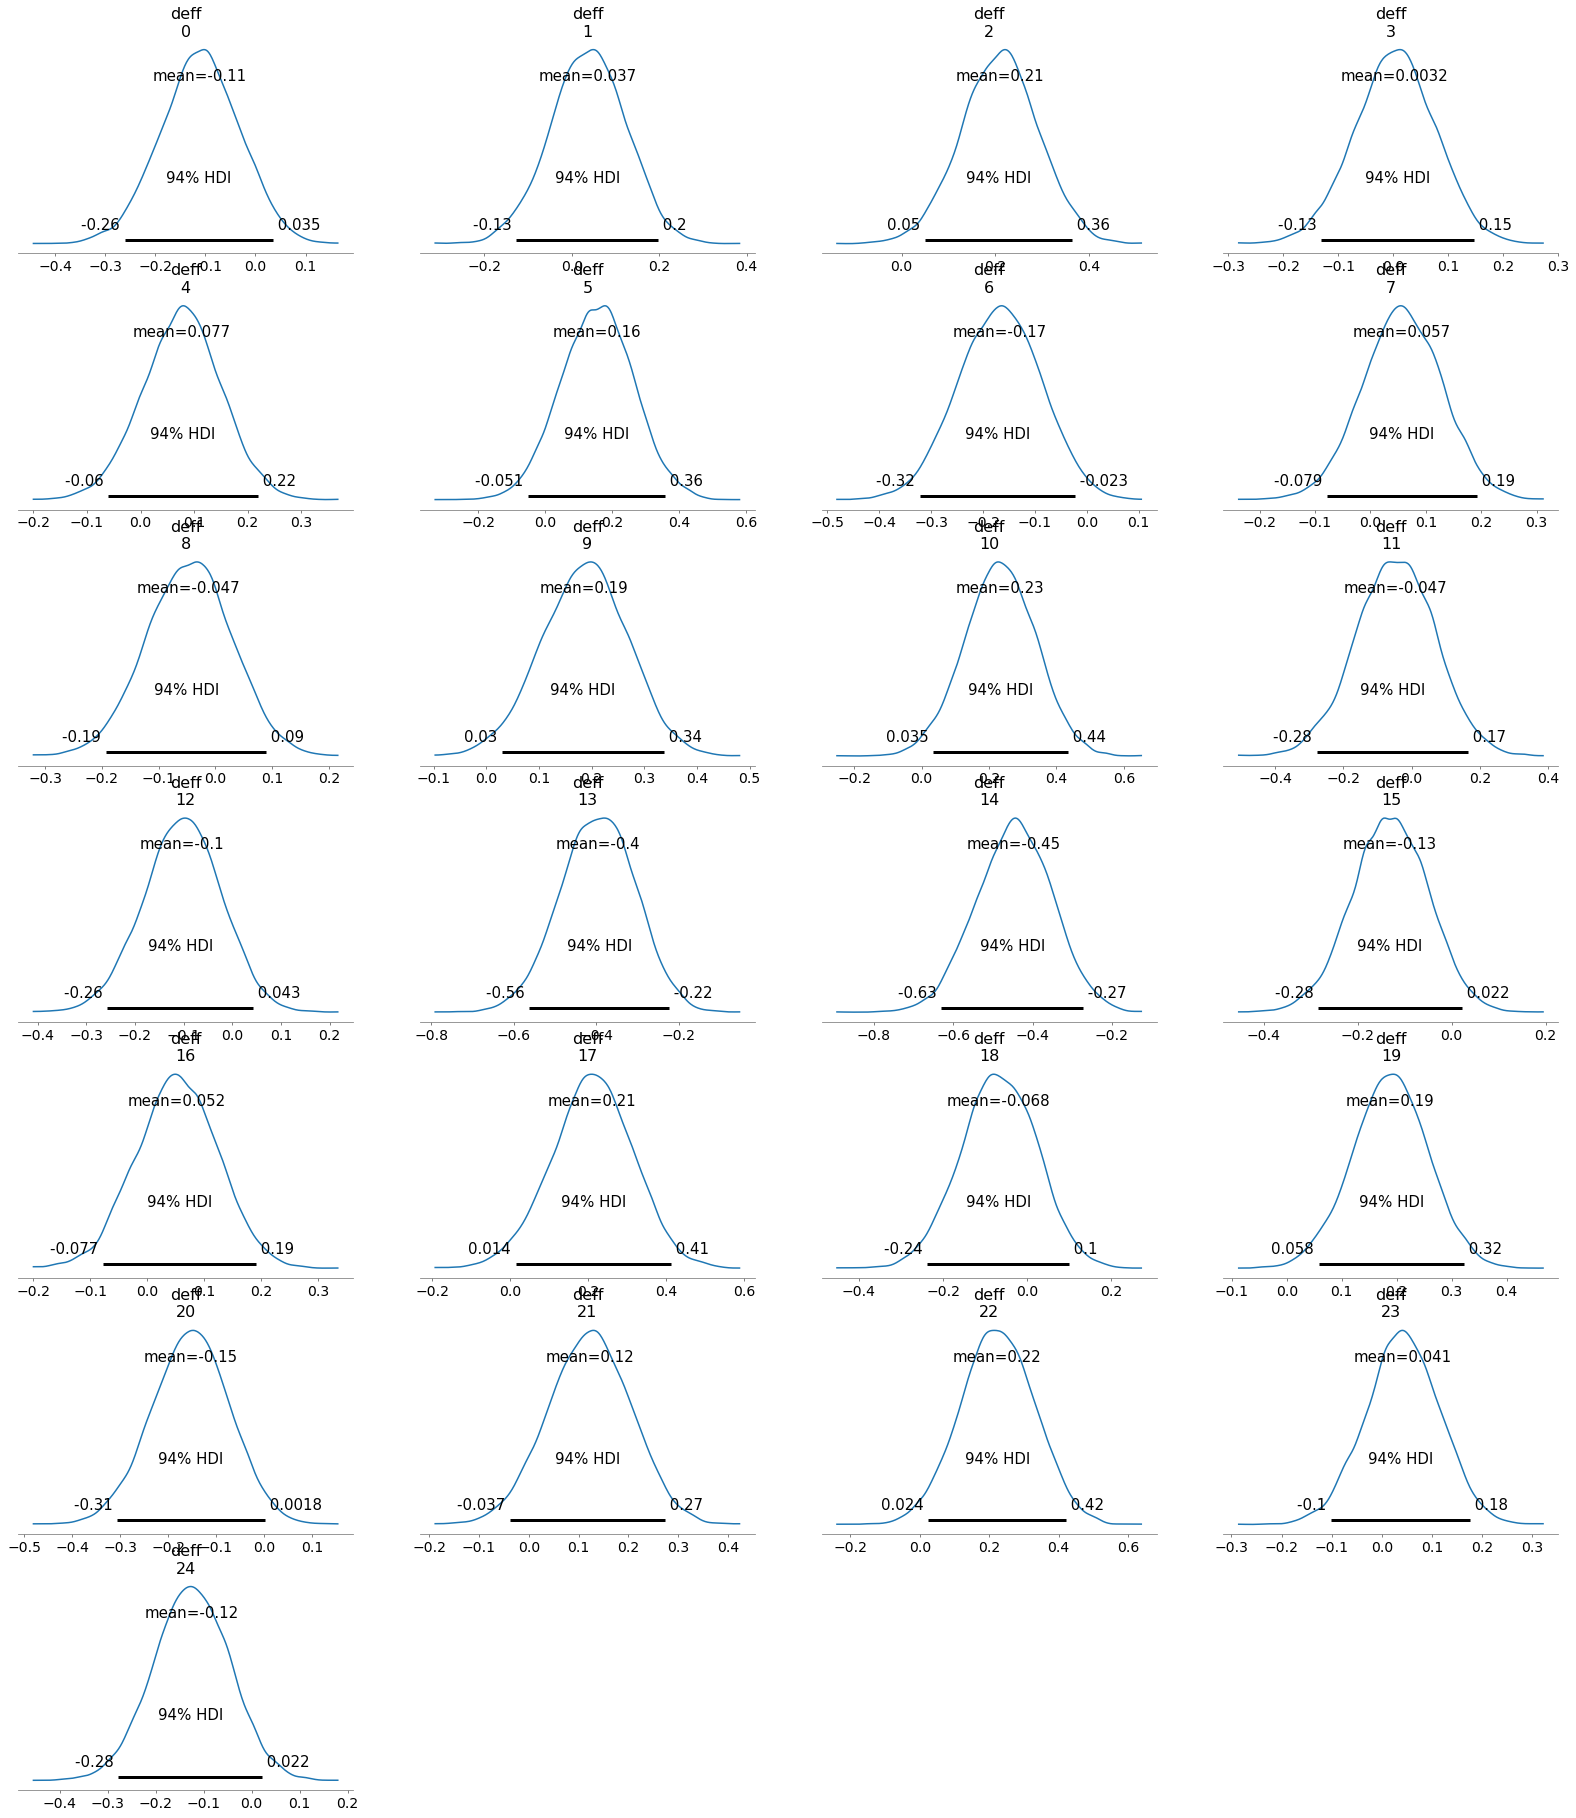

In [59]:
az.plot_posterior(trace, var_names=["deff"]);

# 3 Results

### Table 2: Estimation of the main effects for the loglinear model

In [7]:
def index_to_team_param(x):
    num = int(x.split('[')[1].split(']')[0])
    team_name = list(team_codes_map.keys())[list(team_codes_map.values()).index(num)]
    return team_name

In [8]:
summary_trace = summary_trace[["mean", "sd", "hdi_3%", "hdi_97%"]]

att_param_rows = summary_trace.iloc[-n_teams*2:-n_teams]
deff_param_rows = summary_trace.iloc[-n_teams:]
home_row = summary_trace.iloc[:1]

deff_param_rows.index = deff_param_rows.index.map(index_to_team_param)
att_param_rows.index = att_param_rows.index.map(index_to_team_param)

table_2 = att_param_rows.join(deff_param_rows, lsuffix='_a', rsuffix='_d')
table_2

,mean_a,sd_a,hdi_3%_a,hdi_97%_a,mean_d,sd_d,hdi_3%_d,hdi_97%_d
Arsenal,0.293,0.074,0.151,0.429,-0.111,0.079,-0.261,0.035
Aston Villa,0.037,0.100,-0.148,0.224,0.037,0.087,-0.127,0.198
Bournemouth,0.031,0.102,-0.158,0.224,0.210,0.083,0.050,0.363
Brighton,-0.181,0.092,-0.351,-0.006,0.003,0.074,-0.130,0.147
Burnley,-0.118,0.089,-0.291,0.042,0.077,0.074,-0.060,0.218
Cardiff,-0.386,0.160,-0.688,-0.094,0.156,0.109,-0.051,0.358
Chelsea,0.322,0.072,0.184,0.455,-0.168,0.080,-0.322,-0.023
Crystal Palace,-0.104,0.088,-0.268,0.066,0.057,0.072,-0.079,0.192
Everton,0.056,0.082,-0.099,0.207,-0.047,0.076,-0.193,0.090
Fulham,-0.411,0.121,-0.645,-0.190,0.186,0.082,0.030,0.337


In [9]:
home_row

,mean,sd,hdi_3%,hdi_97%
home,0.275,0.029,0.223,0.33


### Figure 3: Attack vs defense average effect

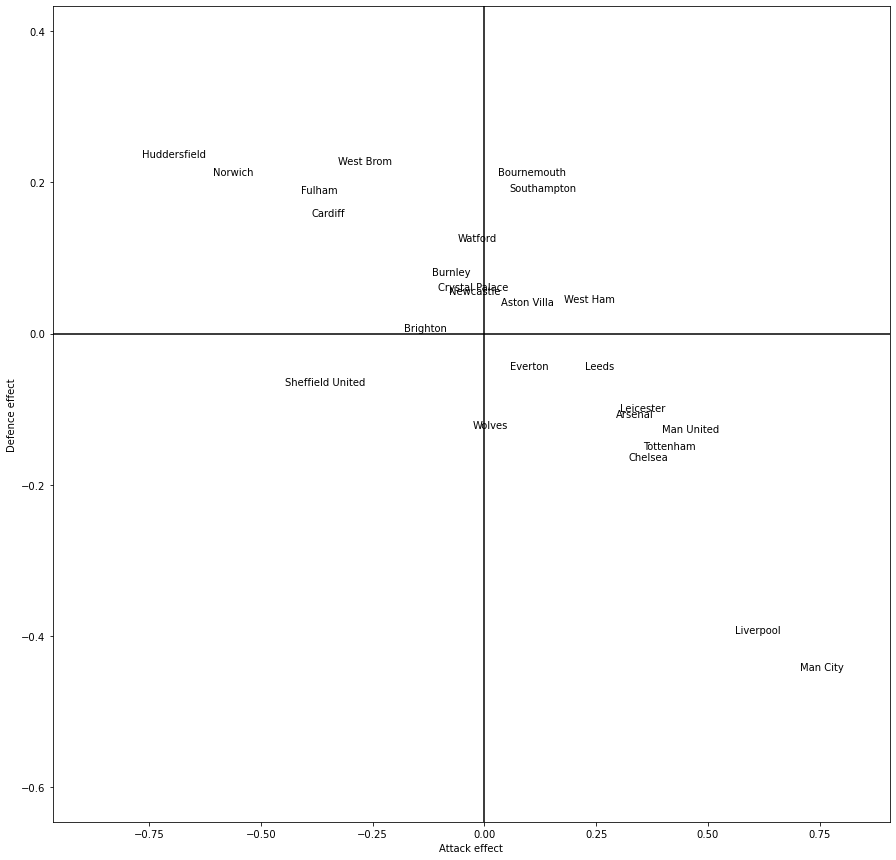

In [58]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.set_xlabel("Attack effect", color='k')
ax.set_ylabel("Defence effect", color='k')

xmin, xmax = min(table_2["mean_a"]) - 0.2, max(table_2["mean_a"]) + 0.2
ymin, ymax = min(table_2["mean_d"]) - 0.2, max(table_2["mean_d"]) + 0.2

ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))

i = 0
for row in table_2.itertuples():
    plt.annotate(teams[i], (row.mean_a, row.mean_d), color='k')
    i += 1
    
plt.plot([xmin, xmax], [0, 0], color='k')
plt.plot([0, 0], [ymin, ymax], color='k')

plt.show()

### Table 3: Posterior predictive validation of the model. Observed and estimated league table


In [60]:
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace, 
                                                          var_names=["att", "deff", "y_1", "y_2"])

In [61]:
# dataset for prediction is the final season in the training data
prediction_season_df = dataset[760 :].reset_index()

# remove the first 760 columns corresponding to the first 2 seasons in the dataset
home_goals_pred_season = np.delete(posterior_predictive["y_1"], slice(0, 760), axis=1)
away_goals_pred_season = np.delete(posterior_predictive["y_2"], slice(0, 760), axis=1)

In [62]:
def calcMedianSeasonGoalsFor(posterior_predictive, teamName, prediction_season_df, 
                             home_goals_pred_season, away_goals_pred_season):
    
    all_rows =  [i for i in range(len(prediction_season_df))]
    
    # Home
    teams_rows = prediction_season_df[prediction_season_df["HomeTeam"] == teamName].index.values  # List of columns that contains TEAMS info
    rows_to_delete = list(set(all_rows) - set(teams_rows))  # Columns that don't correspond to TEAM

    teams_goals_h = np.delete(home_goals_pred_season, rows_to_delete, axis=1)  # TEAMs info   
    total_goals_h = teams_goals_h.sum(axis=1)  # TEAMs total home goals for each sample   
    
    # Away
    teams_rows = prediction_season_df[prediction_season_df["AwayTeam"] == teamName].index.values  # List of columns that contains TEAMS info
    rows_to_delete = list(set(all_rows) - set(teams_rows))  # Columns that don't correspond to TEAM
    
    teams_goals_a = np.delete(away_goals_pred_season, rows_to_delete, axis=1)  # TEAMs info   
    total_goals_a = teams_goals_a.sum(axis=1)  # TEAMs total home goals for each sample  
    
    # Sum home and away, then calculate median estimate
    return np.median(total_goals_h + total_goals_a)

In [63]:
def calcMedianSeasonGoalsAgainst(posterior_predictive, teamName, prediction_season_df, 
                                 home_goals_pred_season, away_goals_pred_season):
    
    all_rows =  [i for i in range(len(prediction_season_df))]
    
    # Home
    teams_rows = prediction_season_df[prediction_season_df["AwayTeam"] == teamName].index.values  # List of columns that contains TEAMS info
    rows_to_delete = list(set(all_rows) - set(teams_rows))  # Columns that don't correspond to TEAM

    teams_goals_h = np.delete(home_goals_pred_season, rows_to_delete, axis=1)  # TEAMs info   
    total_goals_h = teams_goals_h.sum(axis=1)  # TEAMs total home goals for each sample   
    
    # Away
    teams_rows = prediction_season_df[prediction_season_df["HomeTeam"] == teamName].index.values  # List of columns that contains TEAMS info
    rows_to_delete = list(set(all_rows) - set(teams_rows))  # Columns that don't correspond to TEAM
    
    teams_goals_a = np.delete(away_goals_pred_season, rows_to_delete, axis=1)  # TEAMs info   
    total_goals_a = teams_goals_a.sum(axis=1)  # TEAMs total home goals for each sample  
    
    # Sum home and away, then calculate median estimate
    return np.median(total_goals_h + total_goals_a)

In [64]:
def calcPoints(posterior_predictive, teamName, prediction_season_df,
               home_goals_pred_season, away_goals_pred_season):
    
    all_rows =  [i for i in range(len(prediction_season_df))]
    
    # Home
    teams_rows = prediction_season_df[prediction_season_df["HomeTeam"] == teamName].index.values  # List of columns that contains TEAMS info
    rows_to_delete = list(set(all_rows) - set(teams_rows))  # Columns that don't correspond to TEAM

    teams_goals_h = np.delete(home_goals_pred_season, rows_to_delete, axis=1)  # TEAMs info  
    oppTeams_goals_h = np.delete(away_goals_pred_season, rows_to_delete, axis=1)  # Opposition goals

    points_per_game_h = (teams_goals_h > oppTeams_goals_h)*3 + (teams_goals_h == oppTeams_goals_h)  # ppg when the home team
    total_points_h = points_per_game_h.sum(axis=1)  # TEAMs total home points for each sample   

    # Away
    teams_rows = prediction_season_df[prediction_season_df["AwayTeam"] == teamName].index.values  # List of columns that contains TEAMS info
    rows_to_delete = list(set(all_rows) - set(teams_rows))  # Columns that don't correspond to TEAM

    teams_goals_a = np.delete(away_goals_pred_season, rows_to_delete, axis=1)  # TEAMs info  
    oppTeams_goals_a = np.delete(home_goals_pred_season, rows_to_delete, axis=1)  # Opposition goals

    points_per_game_a = (teams_goals_a > oppTeams_goals_a)*3 + (teams_goals_a > oppTeams_goals_a)  # ppg when the home team
    total_points_a = points_per_game_a.sum(axis=1)  # TEAMs total home points for each sample   

    return np.median(total_points_h + total_points_a)

In [65]:
table_3_df = pd.DataFrame({
    "team": prediction_season_df["HomeTeam"].unique(), 
    "observed_points": 0, 
    "observed_scored": 0, 
    "observed_conceded": 0,
    "model_points": 0,
    "model_scored": 0,
    "model_conceded": 0
})

In [66]:
obs_points = {team: 0 for team in teams}
obs_scored = obs_points.copy()
obs_conceded = obs_points.copy()

for index, row in prediction_season_df.iterrows():
    obs_scored[row["HomeTeam"]] += row["FTHG"]
    obs_scored[row["AwayTeam"]] += row["FTAG"]
    
    obs_points[row["HomeTeam"]] += 3*(row["FTR"] == "H") + (row["FTR"] == "D")
    obs_points[row["AwayTeam"]] += 3*(row["FTR"] == "A") + (row["FTR"] == "D")    
    
    obs_conceded[row["HomeTeam"]] += row["FTAG"]
    obs_conceded[row["AwayTeam"]] += row["FTHG"]

In [70]:
table_3_df["observed_points"] = table_3_df["team"].apply(lambda x: obs_points[x])
table_3_df["observed_scored"] = table_3_df["team"].apply(lambda x: obs_scored[x])
table_3_df["observed_conceded"] = table_3_df["team"].apply(lambda x: obs_conceded[x])

table_3_df["model_points"] = table_3_df["team"].apply(lambda x: calcPoints(posterior_predictive, x, prediction_season_df, home_goals_pred_season, away_goals_pred_season))
table_3_df["model_scored"] = table_3_df["team"].apply(lambda x: calcMedianSeasonGoalsFor(posterior_predictive, x, prediction_season_df, home_goals_pred_season, away_goals_pred_season))
table_3_df["model_conceded"] = table_3_df["team"].apply(lambda x: calcMedianSeasonGoalsAgainst(posterior_predictive, x, prediction_season_df, home_goals_pred_season, away_goals_pred_season))

In [71]:
table_3_df.sort_values(by="observed_points", ascending=False).reset_index().drop(columns="index")

,team,observed_points,observed_scored,observed_conceded,model_points,model_scored,model_conceded
0,Man City,86,83,32,94.0,88.0,31.0
1,Man United,74,73,44,69.0,64.0,44.0
2,Liverpool,69,68,42,86.0,76.0,33.0
3,Chelsea,67,58,36,67.0,59.0,42.0
4,Leicester,66,68,50,64.0,58.0,45.0
5,West Ham,65,62,47,53.0,51.0,53.0
6,Tottenham,62,68,45,68.0,61.0,43.0
7,Arsenal,61,55,39,64.0,57.0,45.0
8,Everton,59,47,48,51.0,45.0,48.0
9,Leeds,59,62,54,58.0,53.0,48.0
